In [16]:
%load_ext autoreload
%autoreload 2
import main
import glob
import os
import pickle
import pandas
import torch
from torch import autograd

import helpers
import defaults
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt

In [18]:
storedir = './checkpoints_20200518'
args = main.config(storedir=storedir)
arg_files = glob.glob(os.path.join(args.storedir, '**/args.txt'), recursive=True)
kwargs = [helpers.load_dict(argfile) for argfile in arg_files]
for k,f in zip(kwargs, arg_files):
    if k['perturb_reg'] <= 0.00000 and k['lr2'] <= 40:
        print(f)

./checkpoints_20200518/1e421d18-7a23-495d-bf0c-fcafb36a516e/args.txt
./checkpoints_20200518/08c3bf94-40fe-4fed-880c-fd99732ebc96/args.txt
./checkpoints_20200518/42f2cccc-3686-480e-97f6-a3ffc4168045/args.txt
./checkpoints_20200518/1e891baf-77b3-4358-90ff-df17329cdb77/args.txt
./checkpoints_20200518/aa0f1301-7ef2-4d0f-8889-70f892f64d80/args.txt
./checkpoints_20200518/815cc602-db2d-4c9e-bbf5-046d5a223425/args.txt
./checkpoints_20200518/f20bc74a-a32a-4a22-a8d6-e305dba5f6f4/args.txt
./checkpoints_20200518/00e2774e-30ba-46aa-b732-1a666686d679/args.txt
./checkpoints_20200518/4e31928f-dba6-4fa1-85d2-e9f32dcf7a64/args.txt
./checkpoints_20200518/89947d74-7c02-4b4d-a73c-d6cdc8308313/args.txt
./checkpoints_20200518/20595c11-1d95-431f-8759-1bf1a6029383/args.txt
./checkpoints_20200518/375fba39-a834-45da-b3bc-8f38d218dce2/args.txt


In [102]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', default=None, nargs='+', type=int)
parser.parse_args('')


Namespace(epoch=None)

In [19]:
from tqdm.auto import tqdm

args = main.config(storedir=storedir)
arg_files = glob.glob(os.path.join(args.storedir, '**/args.txt'), recursive=True)
exp_dirs = [os.path.dirname(f) for f in arg_files]

variables = ['lr1','lr2', 'perturb_reg']
outputs = ['test_accuracy','adv_accuracy']

epoch = 14
df = pandas.DataFrame()
for exp_dir in exp_dirs:
    # change this
    kwargs = helpers.load_dict(os.path.join(exp_dir, defaults.ARG_FILE))
    kwargs['storedir'] = storedir
    args = main.config(**kwargs)
    (train_loader, test_loader), device = main.load(args)
    models, _ = main.init(args, device, shape=train_loader.shape)
    checkpoints = [os.path.join(exp_dir, f'save{epoch:03d}.pt'),
                   os.path.join(exp_dir, f'save_perturb{epoch:03d}.pt')]

    try:
        for m,c in zip(models, checkpoints):
            m.load_state_dict(torch.load(c))
    except:
        print("files missing")
        continue
                

    for eps in [0.01,0.05,0.1,0.5,1.0]:
        model, perturb = models
        model.to(device)
        perturb.to(device)
        args.adv_epsilon=eps
        args.adv_norm='infty'
        out = main.test_adv(-1, args, model, device, test_loader)
        df = df.append(dict(eps=eps, **{k:kwargs[k] for k in variables},
                            **{k:out[k] for k in outputs}),
                      ignore_index=True)
    df.to_pickle(os.path.join(args.storedir, 'eval.pkl'))

/home/ben/dev/learning-in-games/main.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturb = torch.tensor(torch.zeros(*test_loader.shape), requires_grad=True, device=device)


KeyboardInterrupt: 

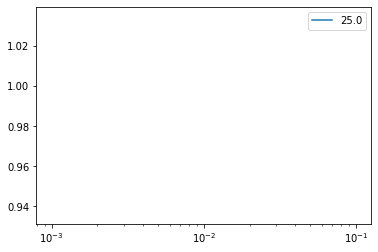

In [20]:
plt.plot(df['eps'], df['adv_accuracy'])
plt.legend(list(df['lr2']))
plt.xscale('log')

Text(0, 0.5, 'adversarial accuracy (eps=0.5)')

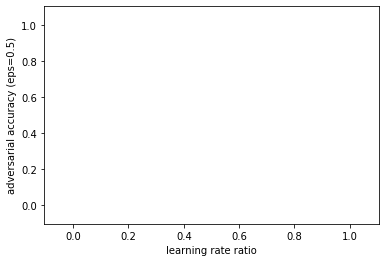

In [21]:
ddf = df[df['eps']==.5]
ddf = ddf[ddf['perturb_reg']<=0.0001]
ddf = ddf[ddf['lr2'] <= 40]
plt.plot(ddf['lr2']/ddf['lr1'], ddf['adv_accuracy'],'o') 
plt.plot(ddf['lr2']/ddf['lr1'], ddf['test_accuracy'],'o') 
plt.xlabel('learning rate ratio')
plt.ylabel('adversarial accuracy (eps=0.5)')

Text(0, 0.5, 'adversarial accuracy')

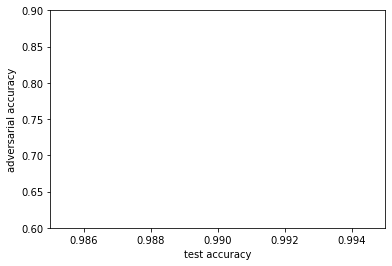

In [22]:
plt.plot(ddf['test_accuracy'], ddf['adv_accuracy'],'o') 
plt.xlim([0.985,.995])
plt.ylim([.6,.9])
plt.xlabel('test accuracy')
plt.ylabel('adversarial accuracy')

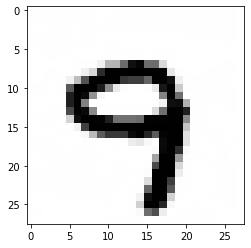

In [23]:
plt.imshow(out['adv_data'][0,0].cpu().detach(), cmap='Greys')

In [24]:
plt.imshow(Dperturb_loss[0,0].cpu().detach().numpy(), cmap='Greys')

NameError: name 'Dperturb_loss' is not defined

In [25]:
import torchvision

def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



exp_dir = exp_dirs[4]


for i in range(14):
    args = main.config(**kwargs)
    (m,p),_ = main.init(args, 'cpu', [64,1,28,28])
    savefile = os.path.join(exp_dir, f'save_perturb{i+1:03d}.pt')
    p.load_state_dict(torch.load(savefile))
    delta = [_ for _ in p.parameters()][0]
    show(torchvision.utils.make_grid(delta, normalize=True))
    plt.show()

NameError: name 'np' is not defined

In [ ]:
import torch
m.load_state_dict(torch.load(savefile))

In [ ]:
import numpy as np
np.random.rand(2)

In [ ]:
delta

In [38]:
import time
time.strftime('%Y-%m-%d')

'2020-05-19'

In [53]:
os.path.relpath(exp_dir, storedir)

'425784f2-302b-466d-9c0b-9af3ad41ab9a'

In [43]:
exp_dir

'./checkpoints_20200518/425784f2-302b-466d-9c0b-9af3ad41ab9a'

In [54]:
df

,adv_accuracy,eps,lr1,lr2,perturb_reg,test_accuracy
0,0.9853,0.01,0.1,25.0,0.0,0.9868


In [73]:
df = pandas.DataFrame()
df = df.append(dict(a=1, b=1, c=2), ignore_index=True)
df = df.append(dict(a=1, b=2, c=3), ignore_index=True)
df

,a,b,c
0,1.0,1.0,2.0
1,1.0,2.0,3.0


In [74]:
df[(df.a == 1) & (df.c==2)]

,a,b,c
0,1.0,1.0,2.0


In [75]:
import pandas as pd
len(pd.unique(df.a))

1

In [84]:
cols = [col for col in df.columns if len(pd.unique(df[col])) > 1 ]
cols

['b', 'c']

In [107]:
abc = 'hello world'
text = '{abc}'
f''+text

'{abc}'

In [109]:
def fstr(template):
    return eval(f"f'{template}'")
template_a = "The current name is {name}"
names = ["foo", "bar"]
for name in names:
    print(fstr(template_a))

The current name is foo
The current name is bar


In [126]:
import itertools

grid_search = dict(adv_epsilon=[0.01,0.05,0.1,0.5,1.0], adv_norm=['infty', 'l2'])
k,v = grid_search.items()
list(itertools.product(*grid_search.values()))


[(0.01, 'infty'),
 (0.01, 'l2'),
 (0.05, 'infty'),
 (0.05, 'l2'),
 (0.1, 'infty'),
 (0.1, 'l2'),
 (0.5, 'infty'),
 (0.5, 'l2'),
 (1.0, 'infty'),
 (1.0, 'l2')]

In [127]:
grid_search.keys()

dict_keys(['adv_epsilon', 'adv_norm'])